In [2]:
import datetime
import pandas as pd
import numpy as np
import time 
import pandas_datareader.data as web 
import timeout_decorator
from yahoofinancials import YahooFinancials
from yahoo_earnings_calendar import YahooEarningsCalendar
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# EPS、売上高予想取得（ガイダンス取得）関数

#実行時に帰ってこないことがあるのでtimeoutを設定
@timeout_decorator.timeout(60)

def yf_estimate(ticker):
   #ticker = 'BIDU'

   url = 'https://finance.yahoo.com/quote/'+ticker+'/analysis?p='+ticker
   dfs = pd.read_html(url)

   # EPS予想
   earning_estimate_df = dfs[0].loc[:, ~dfs[0].columns.str.contains('Year')]
   earning_estimate_df = earning_estimate_df[earning_estimate_df['Earnings Estimate'] == 'Avg. Estimate']
   earning_estimate_df.drop('Earnings Estimate',axis=1,inplace=True)

   #売上予想
   revenue_estimate_df = dfs[1].loc[:, ~dfs[1].columns.str.contains('Year')]
   revenue_estimate_df = revenue_estimate_df[revenue_estimate_df['Revenue Estimate'] == 'Avg. Estimate']
   revenue_estimate_df.drop('Revenue Estimate',axis=1,inplace=True)
   
   #EPS、売上結合
   estimate_df = pd.concat([earning_estimate_df, revenue_estimate_df], sort = True)
   estimate_df = estimate_df.reset_index(drop=True)

   # 単位変換（0に戻す）
   d = {'B': '*10 ** 9', 'M': '*10 ** 6', 'k': '*10 ** 3'}
   for col in estimate_df.columns:
        if estimate_df[col].dtype == 'object':
           estimate_df[col] =  estimate_df[col].replace(d, regex=True).map(pd.eval)
  
   #列名変更
   for col in estimate_df.columns:
       #文字列の変換
       if 'Current Qtr.' in col:
           rep_col = col.replace('Current Qtr.','今季予想')
       else:
           rep_col = col.replace('Next Qtr.','来季予想')
       
       estimate_df = estimate_df.rename(columns = {col:rep_col})

   #df整形
   estimate_df = estimate_df.T
   estimate_df = estimate_df.rename(columns={1:'売上高予想'})
   estimate_df = estimate_df.rename(columns={0:'EPS予想'})
   estimate_df = estimate_df.reset_index()
   estimate_df = estimate_df.rename(columns={'index':'quarter'}) 
   estimate_df.insert(0, 'ticker', ticker)
   estimate_df = estimate_df.reindex(columns = ['ticker','quarter','EPS予想','売上高予想'])
   estimate_df['データ取得日'] = datetime.date.today().strftime('%Y/%m/%d')
   
   return estimate_df

In [4]:
# EPS、売上高結果取得関数

@timeout_decorator.timeout(60)
def yf_actual(ticker):

   tick = YahooFinancials(ticker)

   #データ取得 
   get_stock_earnings_data = tick.get_stock_earnings_data()

   #eps,売上結果取得
   earnings_df = get_stock_earnings_data[ticker]['earningsData']['quarterly']
   earnings_df = pd.DataFrame(earnings_df)

   financials_df = get_stock_earnings_data[ticker]['financialsData']['quarterly']
   financials_df = pd.DataFrame(financials_df)

   #eps,売上結合
   if not earnings_df.empty:
       #空じゃなければ
       actual_df = pd.merge(earnings_df,financials_df, left_on=['date'], right_on=['date'],how='left')
   else:
       #空なら
       actual_df = financials_df

   #整形
   actual_df = actual_df.rename(columns = {'actual':'EPS結果'})
   actual_df = actual_df.rename(columns = {'revenue':'売上高結果'})
   actual_df.drop('earnings',axis=1,inplace=True)
   
   if not earnings_df.empty:
       #空じゃなければ
       actual_df.drop('estimate',axis=1,inplace=True)
   
   actual_df = actual_df.set_index('date')
   actual_df = actual_df.reset_index()
   actual_df = actual_df.rename(columns = {'date':'quarter'}) 
   actual_df.insert(0, 'ticker', ticker)
   actual_df['データ取得日'] = datetime.date.today().strftime('%Y/%m/%d')
   
   return actual_df

In [5]:
# EPSの結果と過去予想の一覧を取る関数
#tickerのEPS結果と過去予想一覧がとれる

def yf_old_eps(ticker):

   yec = YahooEarningsCalendar()
   wao =yec.get_earnings_of(ticker)

   #seriesからdfに変換
   df = pd.DataFrame(wao)

   #過去２年に絞る
   today = datetime.date.today().strftime('%Y/%m/%d')
   df =df[(df['startdatetime'] > '2019-01-01') & (df['startdatetime']  <= today)]
   
   #整形
   df =df[['ticker','startdatetime','epsactual','epsestimate','epssurprisepct']]
   df['startdatetime'] =  pd.to_datetime(df['startdatetime']).dt.strftime('%Y/%m/%d')
   
   df = df.rename(columns = {'startdatetime':'決算日'})
   df = df.rename(columns = {'epsactual':'EPS結果'})   
   df = df.rename(columns = {'epsestimate':'EPS予想'})  
   df['データ取得日'] = datetime.date.today().strftime('%Y/%m/%d')    
   
   return df

In [6]:
def yf_chart(ticker,chart_days):
   
    #日付計算
   today = datetime.date.today().strftime('%Y/%m/%d')
   start_day = datetime.date.today() - datetime.timedelta(days=chart_days)
   start_day = start_day.strftime('%Y/%m/%d')

   df = web.DataReader(ticker,"yahoo",start_day,today)
   return df[['Close']].plot(figsize=(15, 5), lw=2)

OKTA


■chart


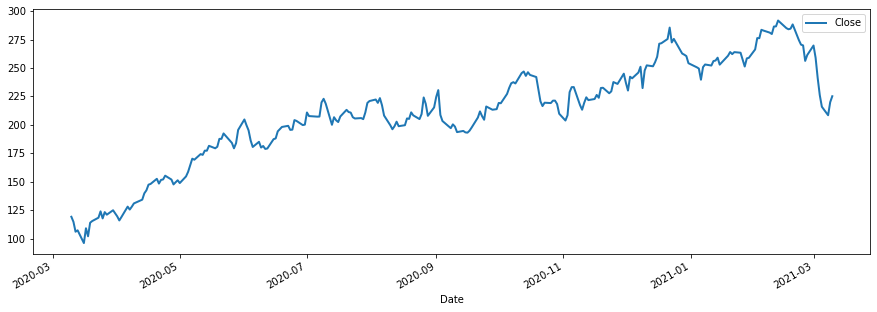

OKTA


■予想


,ticker,quarter,EPS予想,売上高予想,データ取得日
0,OKTA,今季予想 (Apr 2021),-0.20,238430000.00,2021/03/11
1,OKTA,来季予想 (Jul 2021),-0.11,258480000.00,2021/03/11


■結果


,ticker,quarter,EPS結果,売上高結果,データ取得日
0,OKTA,2Q2020,-0.07,182859000,2021/03/11
1,OKTA,3Q2020,0.07,200446000,2021/03/11
2,OKTA,4Q2020,0.04,217379000,2021/03/11
3,OKTA,1Q2021,0.06,234740000,2021/03/11


■過去EPS


,ticker,決算日,EPS結果,EPS予想,epssurprisepct,データ取得日
1,OKTA,2021/11/01,nan,nan,nan,2021/03/11
2,OKTA,2021/08/25,nan,nan,nan,2021/03/11
3,OKTA,2021/05/26,nan,-0.20,nan,2021/03/11
4,OKTA,2021/03/03,0.06,-0.01,645.45,2021/03/11
5,OKTA,2020/12/02,0.04,-0.01,433.33,2021/03/11
6,OKTA,2020/08/27,0.07,-0.02,468.42,2021/03/11
7,OKTA,2020/05/28,-0.07,-0.17,60.00,2021/03/11
8,OKTA,2020/03/05,-0.01,-0.05,78.26,2021/03/11
9,OKTA,2019/12/05,-0.07,-0.12,42.15,2021/03/11
10,OKTA,2019/08/28,-0.05,-0.11,52.83,2021/03/11


ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー


In [7]:
#調べたいものをリストで設定
tickers = ['OKTA']

#リストを回す
for ticker in tickers:
    
   print(ticker)
   print('\n')
   print('■chart')

   display(yf_chart('OKTA',365))
   plt.pause(1)
   
   print(ticker)
   print('\n')
   
   print('■予想')
   display(yf_estimate(ticker))
   
   print('■結果')
   display(yf_actual(ticker))
   
   print('■過去EPS')
   display(yf_old_eps(ticker))

   print('ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー')